In [14]:
import torch
import matplotlib.pyplot as plt
from tqdm import trange

import pymc as pm
import pytensor as pt
from pymc import PolyaGamma as PG

In [28]:
def _compute_mean_a(v, b, theta, w, y):
    S = torch.sum(torch.mul(theta, y-0.5-torch.mul(b, w)))
    mean = v*S
    return mean.item()

def _compute_var_a(sigmasq, theta, w):
    S = torch.sum(torch.mul(w, torch.pow(theta, 2))) + 1/sigmasq
    var = 1/S
    return var.item()

def _compute_mean_b(v, a, theta, w, y):
    S = torch.sum(y-0.5-a*torch.mul(theta, w))
    mean = v*S
    return mean.item()

def _compute_var_b(sigmasq, w):
    S = torch.sum(w) + 1/sigmasq
    var = 1/S
    return var.item()

def _compute_mean_t(v, a, b, w, y):    
    S = torch.sum(torch.mul(a, y-0.5-torch.mul(b, w)))
    mean = v*S
    return mean.item()    

def _compute_var_t(sigmasq, w, a):
    S = torch.sum(torch.mul(w, torch.pow(a, 2))) + 1/sigmasq
    var = 1/S
    return var.item()


def polyagamma(init_a, init_b, init_t, init_w, y, sigmasq_a, sigmasq_b, sigmasq_t, niter=10000):

    assert init_a.shape == init_b.shape
    assert init_t.shape[0] == y.shape[0]
    assert y.shape == init_w.shape
    
    I = len(init_a)
    P = len(init_t)
    
    # samples
    A = torch.empty(size=(niter, I))
    B = torch.empty(size=(niter, I))
    THETA = torch.empty(size=(niter, P))
    W = torch.empty(size=(niter, P, I))
    
    A[0] = init_a
    B[0] = init_b
    THETA[0] = init_t
    W[0] = init_w

    print(f"Starting Gibbs sampler for Polya-Gamma... \n--------------------------------------------\n")
    for s in trange(1, niter):

        # calculate scale values for PG draw
        Z = torch.abs(torch.mul(torch.t(THETA[s-1, None]), A[s-1, None]) + B[s-1])  
        assert Z.shape == (P, I)
        
        # sample Ws
        W[s] = torch.from_numpy(pm.draw(PG.dist(h=1, z=Z)))

        # sample As
        for i in range(I):
            var_a = _compute_var_a(sigmasq_a, THETA[s-1], W[s][:,i])
            mean_a = _compute_mean_a(var_a, B[s-1][i], THETA[s-1], W[s][:,i], y[:,i])
            A[s][i] = torch.distributions.Normal(mean_a, var_a).sample()

        # sample Bs
        for i in range(I):
            var_b = _compute_var_b(sigmasq_b, W[s][:,i])
            mean_b = _compute_mean_b(var_b, A[s][i], THETA[s-1], W[s][:,i], y[:,i])
            B[s][i] = torch.distributions.Normal(mean_b, var_b).sample()

        # sample THETAs
        for p in range(P):
            var_t = _compute_var_t(sigmasq_t, W[s][p], A[s])
            mean_t = _compute_mean_t(var_t, A[s], B[s], W[s][p,:], y[p,:])
            THETA[s][p] = torch.distributions.Normal(mean_t, var_t).sample()

    return A, B, THETA, W

In [16]:
# TEST

N = 10000   # iterations
I = 100     # exam items
P = 1000    # pupils
sigmasq_a, sigmasq_b, sigmasq_t = torch.tensor([1.0]), torch.tensor([1.0]), torch.tensor([1.0])  # priors

init_a = torch.zeros(I)  
init_b = torch.zeros(I)  
init_t = torch.zeros(P)
init_W = torch.zeros(P, I)

true_a, true_b = torch.empty(size=(I,)), torch.empty(size=(I,))  # items' difficulty and discriminatory power
true_theta = torch.empty(size=(P,))  # students' skills
true_W = torch.empty(size=(P,I))

# populate a, b:
for i in range(I):
    U1 = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    true_a[i] = U1.sample()
    
    U2 = torch.distributions.Uniform(torch.tensor([-1.0]), torch.tensor([0.0]))
    true_b[i] = U2.sample()

# populate theta:
for p in range(P):
    U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    true_theta[p] = U.sample()

# populate W:
scales = torch.mul(torch.t(true_a[:, None]), true_theta[:, None]) + true_b
true_W = torch.from_numpy(pm.draw(PG.dist(h=1, z=scales)))
        
# exam data:
Y = torch.empty(size=(P, I))

for i in range(I):
    for p in range(P):
        prob = torch.exp(true_a[i]*true_theta[p] + true_b[i]) / (1 + torch.exp(true_a[i]*true_theta[p] + true_b[i])) 
        B = torch.distributions.Bernoulli(prob)
        Y[p][i] = B.sample()

print(Y)

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 1., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 1., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 0., 1., 0.]])


In [29]:
samples = polyagamma(init_a, init_b, init_t, init_W, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=N)

Starting Gibbs sampler for Polya-Gamma... 
--------------------------------------------



100%|██████████| 9999/9999 [29:03<00:00,  5.74it/s]


In [30]:
print("A:")
print(torch.mean(samples[0], 0))  # mean over the columns
print(true_a)

print("B:")
print(torch.mean(samples[1], 0))  # mean over the columns
print(true_b)

print("THETA:")
print(torch.mean(samples[2], 0))  # mean over the columns
print(true_theta)

print("W:")
print(torch.mean(samples[3], 0))  # mean over the columns
print(true_W)

A:
tensor([ 0.7378,  0.5952, -0.2169,  0.3471,  0.5960,  0.1132,  0.5028,  0.0390,
        -0.2748,  0.6016,  0.8028,  0.2611,  0.3376,  1.0085,  0.0066,  0.8380,
         0.4841,  0.3373,  0.4335,  0.4890,  0.2186, -0.2730,  0.5461,  0.8137,
         0.4107,  0.4309,  0.4536, -0.0534, -0.0036, -0.0381,  1.6149,  0.3558,
         0.7604,  1.6366,  0.7300,  0.6925, -0.0866,  0.4515,  0.6380,  0.9297,
         1.3672,  1.1087,  1.1585, -0.2824,  1.0561,  1.9741,  0.1751,  0.3340,
         0.0766,  0.1410,  0.0203,  1.9955,  1.0628,  1.1604,  0.7421,  0.4897,
         0.3353,  0.1378,  0.6550,  0.5163,  0.3912,  0.6488,  0.2213,  0.5339,
         0.6369,  0.1372,  0.5389,  0.1763,  0.4031, -0.0391, -0.0449,  0.8634,
         0.4393,  0.0749, -0.2087, -0.1976, -0.0611,  0.9170,  0.3559,  0.3361,
         0.6561,  0.4170, -0.0562,  0.8492, -0.0329,  0.4018, -0.2376,  0.4392,
         0.6222, -0.2326,  0.5437,  0.2143,  0.4844,  0.3434,  0.8498, -0.0152,
         1.4796, -0.0345,  0.6535,  0

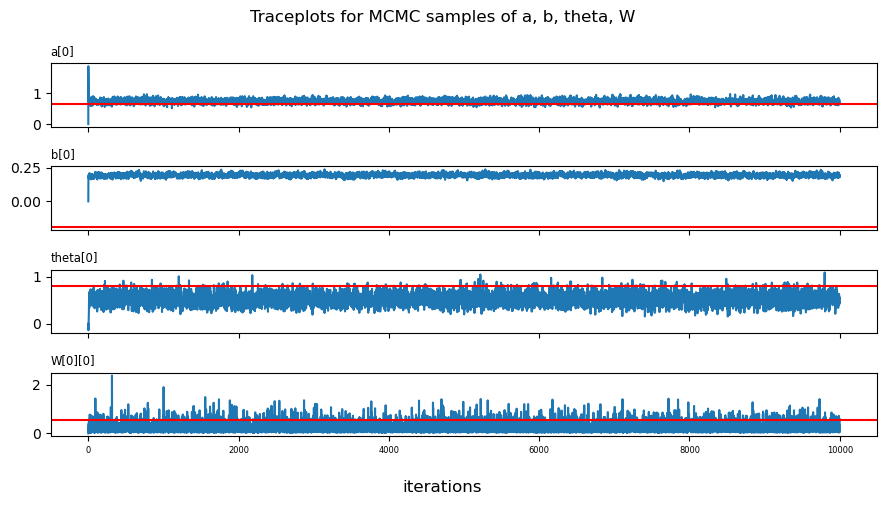

In [31]:
# Traceplots of samples
fig1, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(9,5), sharex=True)
fig1.suptitle('Traceplots for MCMC samples of a, b, theta, W')

t = range(N)

ax1.plot(t, samples[0][:,0])
ax1.axhline(true_a[0], color="red")
plt.tick_params('x', labelsize=6)
ax1.set_title("a[0]", fontsize='small', loc='left')

ax2.plot(t, samples[1][:,0])
ax2.axhline(true_b[0], color="red")
ax2.set_title("b[0]", fontsize='small', loc='left')

ax3.plot(t, samples[2][:,0])
ax3.axhline(true_theta[0], color="red")
ax3.set_title("theta[0]", fontsize='small', loc='left')

ax4.plot(t, samples[3][:,0,0])
ax4.axhline(true_W[0][0], color="red")
ax4.set_title("W[0][0]", fontsize='small', loc='left')

fig1.supxlabel('iterations')
fig1.tight_layout()
plt.show()

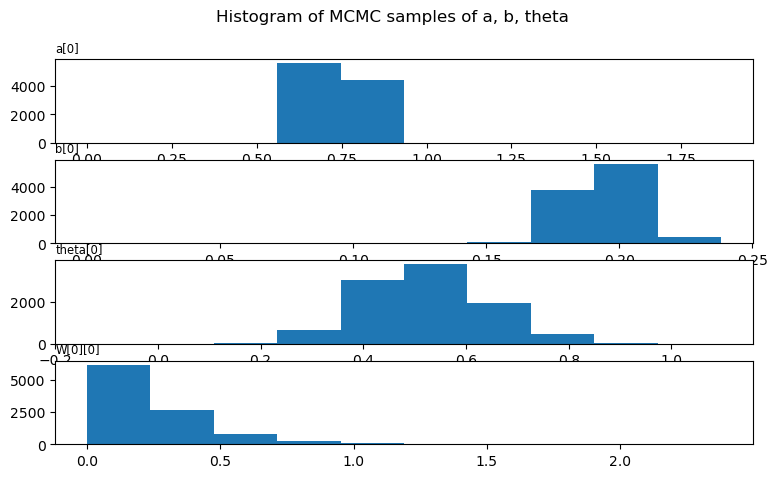

In [32]:
# Histogram of samples
fig2, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(9,5))
fig2.suptitle('Histogram of MCMC samples of a, b, theta')

ax1.hist(samples[0][:,0])
ax1.set_title("a[0]", fontsize='small', loc='left')
ax2.hist(samples[1][:,0])
ax2.set_title("b[0]", fontsize='small', loc='left')
ax3.hist(samples[2][:,0])
ax3.set_title("theta[0]", fontsize='small', loc='left')
ax4.hist(samples[3][:,0,0])
ax4.set_title("W[0][0]", fontsize='small', loc='left')

plt.show()